In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline
import pandas as pd

## EURUSD NEWS


In [67]:
newsDF = pd.read_excel('EURUSDnews.xlsx')
newsDF = newsDF.drop('index',1)
newsDF = newsDF.drop('level_0',1)
newsDF = newsDF.drop('Unnamed: 0',1)
newsDF = newsDF.drop('key',1)
newsDF = newsDF.drop('day',1)
newsDF = newsDF.drop('month',1)
newsDF = newsDF.drop('hour',1)
print(newsDF.head())

                                               title  \
0  EUR/USD pulls back on Friday, still heads for ...   
1  EUR/USD: Fed should help for another visit to ...   
2  EUR/USD: Wider US-DE yield spreads and risk-of...   
3  Forex Today: A hectic weeks kicks off with a s...   
4      EUR/USD probing lows near 1.1720 ahead of IFO   

                                         articleBody               keywords  \
0  US dollar recovers ground as Euro gets hits by...                EURUSD,   
1  Next week, the Federal Reserve will meet. Acco...          EURUSD,Banks,   
2  The EUR/USD fell on Friday, tracking the 10-ye...                EURUSD,   
3  Markets opened quietly this week, belying the ...  EURUSD,Brexit,GBPUSD,   
4  The pair has started the week on a soft footin...                EURUSD,   

                                                 url               pubDate  \
0  https://www.fxstreet.com/news/eur-usd-pulls-ba...  2018-09-21T16:34:04Z   
1  https://www.fxstreet.com/news

In [3]:
import requests
from datetime import datetime
import numpy as np

FUTURE_PERIOD_PREDICT = 1
#newsDF =newsDF.reset_index() 
#startDate = newsDF.loc[0,'date'].timestamp()
startDate = newsDF.loc[0,'date']
startDate = startDate-np.timedelta64(FUTURE_PERIOD_PREDICT,'D')
startDate = startDate.timestamp()
startDate = int(startDate)
print(startDate)
endDate = newsDF.loc[len(newsDF)-1,'date']+np.timedelta64( FUTURE_PERIOD_PREDICT,'D')
endDate = int(endDate.timestamp())
print(endDate)

queryString = 'https://finnhub.io/api/v1/forex/candle?symbol=OANDA:EUR_USD&resolution=D&from='
queryString += str(startDate ) + '&to=' + str(endDate)+ '&token='

columns={'Close','High','Low','Open','Status','timestamp','Volume'}
r = requests.get(queryString)

marketDF = pd.DataFrame(r.json())

marketDF['Close'] = marketDF['c']
marketDF = marketDF.drop('c',1)

marketDF['Open'] = marketDF['o']
marketDF = marketDF.drop('o',1)

marketDF['Low'] = marketDF['l']
marketDF = marketDF.drop('l',1)

marketDF['High'] = marketDF['h']
marketDF = marketDF.drop('h',1)

marketDF = marketDF.drop('s',1)


marketDF['timestamp'] = marketDF['t']
marketDF = marketDF.drop('t',1)

marketDF['Volume'] = marketDF['v']
marketDF = marketDF.drop('v',1)

marketDF['Date'] = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in marketDF['timestamp']]

marketDF = marketDF.drop('timestamp',1)


1537401600
1605225600


In [4]:

print(marketDF.head())
print(marketDF.describe())


     Close     Open      Low     High  Volume        Date
0  1.17765  1.16722  1.16678  1.17842  159764  2018-09-19
1  1.17452  1.17765  1.17320  1.18024  152617  2018-09-20
2  1.17451  1.17421  1.17233  1.18147  125476  2018-09-23
3  1.17647  1.17476  1.17302  1.17919  137517  2018-09-24
4  1.17385  1.17641  1.17250  1.17975  160972  2018-09-25
            Close        Open         Low        High         Volume
count  559.000000  559.000000  559.000000  559.000000     559.000000
mean     1.127417    1.127348    1.124109    1.131253   98078.576029
std      0.028060    0.027971    0.027806    0.028217   54294.828908
min      1.069010    1.068940    1.063470    1.081120       1.000000
25%      1.107735    1.107770    1.105720    1.110605   57937.000000
50%      1.123840    1.123510    1.120920    1.127440   81235.000000
75%      1.139935    1.139795    1.136035    1.144150  126532.000000
max      1.193500    1.193070    1.190060    1.201050  304150.000000


In [5]:
def classify(current, future):
    if float(future) > float(current):  # if the future price is higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0

marketDF.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
marketDF.dropna(inplace=True)

marketDF['future'] = marketDF['Close'].shift(-FUTURE_PERIOD_PREDICT)
marketDF['target'] = list(map(classify, marketDF['Close'], marketDF['future']))
marketDF = marketDF.drop('future',1)

In [6]:
print(marketDF.head())
print(marketDF.describe())

     Close     Open      Low     High  Volume        Date  target
0  1.17765  1.16722  1.16678  1.17842  159764  2018-09-19       0
1  1.17452  1.17765  1.17320  1.18024  152617  2018-09-20       0
2  1.17451  1.17421  1.17233  1.18147  125476  2018-09-23       1
3  1.17647  1.17476  1.17302  1.17919  137517  2018-09-24       0
4  1.17385  1.17641  1.17250  1.17975  160972  2018-09-25       0
            Close        Open         Low        High         Volume  \
count  559.000000  559.000000  559.000000  559.000000     559.000000   
mean     1.127417    1.127348    1.124109    1.131253   98078.576029   
std      0.028060    0.027971    0.027806    0.028217   54294.828908   
min      1.069010    1.068940    1.063470    1.081120       1.000000   
25%      1.107735    1.107770    1.105720    1.110605   57937.000000   
50%      1.123840    1.123510    1.120920    1.127440   81235.000000   
75%      1.139935    1.139795    1.136035    1.144150  126532.000000   
max      1.193500    1.19307

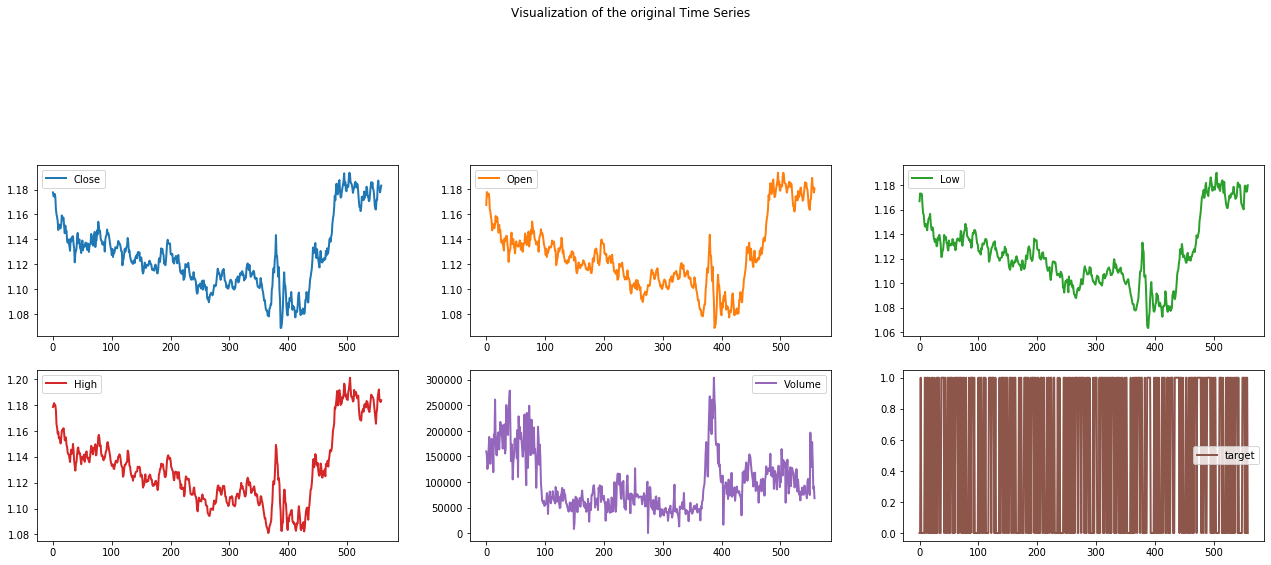

In [7]:
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
import statsmodels.api as sm  # seasonal trend decomposition
from statsmodels.graphics import tsaplots   # autocorrelation
%matplotlib inline
marketDF.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

## assign label up/down to news

In [68]:
newsDF['date']= [pd.to_datetime(w) for w in newsDF['date']]
print(type(newsDF['date'][0]))
marketDF['Date']= [pd.to_datetime(w) for w in marketDF['Date']]
print(type(newsDF['date'][0]))


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [69]:
def assign_dayLabel(date,marketInfo):
    i=0
    while marketInfo['Date'][i] < date:
        i = i+1
    if (marketInfo['Date'][i] == date):
        return(marketInfo['target'][i])
    else:
        return(marketInfo['target'][i-1])

 
newsDF['target'] = [assign_dayLabel(w,marketDF) for w in newsDF['date']]



## train and test split

In [70]:
newsDF = newsDF.set_index('date')
dates = sorted(newsDF.index.values)  # get the dates
last_5pct = sorted(newsDF.index.values)[-int(0.2*len(dates))]  # get the last 20% of the times

test_main_df = newsDF[(newsDF.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = newsDF[(newsDF.index < last_5pct)]  # now the main_df is all the data up to the last 5%

dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.25*len(dates))]  # get the last 20% of the times
validation_main_df =  main_df[(main_df.index > last_5pct)]  
main_df = main_df[(main_df.index < last_5pct)] 

print(main_df.shape)
print(validation_main_df.shape)
print(test_main_df.shape)

print(main_df.head())
print(main_df.describe())

(3555, 14)
(1170, 14)
(1190, 14)
                                                        title  \
date                                                            
2018-09-21  EUR/USD pulls back on Friday, still heads for ...   
2018-09-21  EUR/USD: Fed should help for another visit to ...   
2018-09-24  EUR/USD: Wider US-DE yield spreads and risk-of...   
2018-09-24  Forex Today: A hectic weeks kicks off with a s...   
2018-09-24      EUR/USD probing lows near 1.1720 ahead of IFO   

                                                  articleBody  \
date                                                            
2018-09-21  US dollar recovers ground as Euro gets hits by...   
2018-09-21  Next week, the Federal Reserve will meet. Acco...   
2018-09-24  The EUR/USD fell on Friday, tracking the 10-ye...   
2018-09-24  Markets opened quietly this week, belying the ...   
2018-09-24  The pair has started the week on a soft footin...   

                         keywords  \
date              

In [71]:
def preprocess_df(df):
    phrase = []
    targets = []
    for i,row in df.iterrows():
        phrase.append(row['process_title'])
        targets.append(row['target'])
    X = np.asarray(phrase)
    Y = np.asarray(targets, dtype=int)

    return X, Y
    

In [72]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)
test_x, test_y = preprocess_df(test_main_df)


In [73]:
print(type(test_x[0]))
print(test_x[0])

<class 'numpy.str_'>
['non', 'farm', 'payrolls', 'august', 'preview', 'us', 'dollar', 'waiting', 'good', 'news']


### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">   تبدیل Labelها به بردار One-Hot
</div>


In [75]:
index = 50
print(train_y[index], "is converted into one hot", Y_oh_train[index])

0 is converted into one hot [1. 0.]


### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> تابع کمکی برای خواندن embedding از پیش آموزش داده شده.
</div>


In [28]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map , words

In [62]:
word_to_index, index_to_word, word_to_vec_map , words = read_glove_vecs('D:/phd thesis/dataSet/glove.6B/glove.6B.50d.txt')
embedding_dim = 50 


You've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector 

## 2 - Emojifier-V2: Using LSTMs in Keras: 

Let's build an LSTM model that takes as input word sequences. This model will be able to take word ordering into account. Emojifier-V2 will continue to use pre-trained word embeddings to represent words, but will feed them into an LSTM, whose job it is to predict the most appropriate emoji. 

Run the following cell to load the Keras packages.

In [77]:
import numpy as np
np.random.seed(0)
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation,Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">   تبدیل جمله به indexها 
</div>
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">  
این تابع طول تمام جمله ها را نیز یکسان میکند.
</div>



In [78]:
import re

def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    embedding_dim
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        
        
        sentence_words =  [w.rstrip('\']').lstrip('[\'') for w in X[i].split(',')]
        # Loop over the words of sentence_words
        for j, w in enumerate(sentence_words):
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in total_words:

                word = w.lstrip('[\'')
                word = word.rstrip('\']')
                if len(str(word))>0:
                    X_indices[i, j] = word_to_index[word]
            else:
                 X_indices[i, j] = word_to_index['unk']

    return X_indices

Run the following cell to check what `sentences_to_indices()` does, and check your results.

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">   تابعی برای ایجاد لایه Embedding و لود وزن های از پیش آموزش داده شده 
</div>

In [95]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = embedding_dim      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

## 2.3 Building the Model with Keras Embedding Layer


In [96]:
maxLen = max(newsDF['len_title'])
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):

    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype = np.int32)
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(2, activation = 'softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    
    return model

In [97]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 26, 50)            20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 26, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258 

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [98]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [74]:
Y_oh_train =  keras.utils.to_categorical(train_y,  2)
Y_oh_validation =  keras.utils.to_categorical(validation_y,  2)
Y_oh_test =  keras.utils.to_categorical(test_y, 2)

In [86]:
X_train_indices = sentences_to_indices(train_x, word_to_index, maxLen)
X_validation_indices = sentences_to_indices(validation_x, word_to_index, maxLen)

In [99]:
history = model.fit(X_train_indices, Y_oh_train,
          epochs = 60, batch_size = 32, 
          shuffle=True ,
          validation_data=(X_validation_indices,Y_oh_validation)
         )

Train on 3555 samples, validate on 1170 samples
Epoch 1/60
3555/3555 [==============================] - 54s 15ms/sample - loss: 0.6950 - accuracy: 0.4920 - val_loss: 0.6999 - val_accuracy: 0.3940
Epoch 2/60
3555/3555 [==============================] - 47s 13ms/sample - loss: 0.6941 - accuracy: 0.5150 - val_loss: 0.7046 - val_accuracy: 0.3829
Epoch 3/60
3555/3555 [==============================] - 47s 13ms/sample - loss: 0.6933 - accuracy: 0.5139 - val_loss: 0.7084 - val_accuracy: 0.3829
Epoch 4/60
3555/3555 [==============================] - 46s 13ms/sample - loss: 0.6936 - accuracy: 0.5030 - val_loss: 0.7001 - val_accuracy: 0.3829
Epoch 5/60
3555/3555 [==============================] - 46s 13ms/sample - loss: 0.6931 - accuracy: 0.5131 - val_loss: 0.6973 - val_accuracy: 0.3915
Epoch 6/60
3555/3555 [==============================] - 46s 13ms/sample - loss: 0.6931 - accuracy: 0.5179 - val_loss: 0.7097 - val_accuracy: 0.3829
Epoch 7/60
3555/3555 [==============================] - 46s 13ms

## plot loss for fine-tuned model which causes overfitting

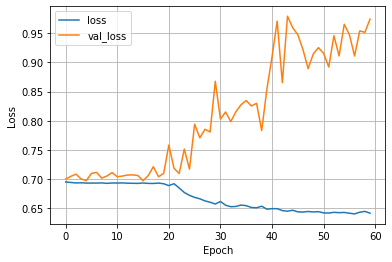

In [100]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)


plot_loss(history)

## plot loss without fine-tuning Glove

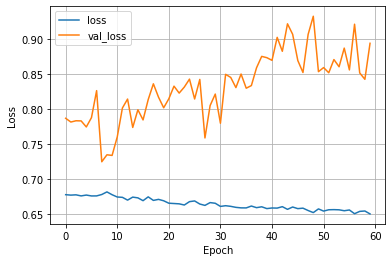

In [92]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [95]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = keras.utils.to_categorical(Y_test, 2)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

765/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Test accuracy =  0.48496732


You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples. 

Now you can try it on your own example. Write your own sentence below. 